In [112]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import os
import datetime as dt
from datetime import datetime,timedelta
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 24
mpl.rcParams["axes.titlesize"] = 24
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 17
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
RESULTS_DIR_F = os.path.join(ROOT_DIR, "results_filtered")


In [113]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

   
def prepare_topics(df,lag,threshold):

    # padding empty columns, sorting columns
    for i in range(200):
        if f"Topic_{i}" not in df.columns:
            df[f"Topic_{i}"] = 0
    df = df[df.columns[df.columns.str[6:].astype(float).argsort()]]

    for i in range(200):
        arr = df.to_numpy()
        y = arr[:,i]

        result = thresholding_algo(y, lag, threshold, influence=0)
        avg_filter = result["avgFilter"]
        threshold_filter = result["avgFilter"] + threshold * result["stdFilter"]
        signals = result["signals"]
        
        for j in range(0,len(signals)):
            if signals[j] < 1:
                signals[j] = -5
            else:
                signals[j] = y[j]

        df[f"avg_filter_topic_{i}"] = avg_filter
        df[f"threshold_filter_topic_{i}"] = threshold_filter
        df[f"signals_topic_{i}"] = signals
        df[f"y_{i}"] = y

    return df

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [114]:
def multi_line_peaks_plot(df, title, threshold):
    topics = [col for col in df.columns if col.startswith("Topic_")]
    series = [df[topic] for topic in topics]
    fig, ax = plt.subplots(figsize=(25, 7))
    beginning, end = dt.date(2022, 1, 1), dt.date(2023,1,1)
    cm = plt.get_cmap('nipy_spectral')
    topic_count = len(series)
    cNorm  = colors.Normalize(vmin=0, vmax=topic_count-1)
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    color_list = [scalarMap.to_rgba(i) for i in range(0,topic_count)]

    for data, color, topic in zip(series, color_list, topics):
        if max(data) >= threshold:
            ax.plot(data.index.values, data, color=color, lw=0.8, alpha=0.7, label=topic)
            
    ax.set(title=title, xbound=(beginning, end),ylim=(0))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
    ax.get_xaxis().set_tick_params(which='both', rotation=0)

    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")
    return fig


In [115]:
def filtered_multi_lines_peaks_plot(df, kwargs, limit):
    fig, ax = plt.subplots(figsize=(25, 7))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)
    title = "Filtered Topic Peaks"

    colors = {
        "red":[15,40,49,72, 56, 61, 65, 68, 72, 97,107, 159, 177, 180, 181, 185, 114],
        "blue":[0, 12, 35, 39,41, 50, 80, 115, 122, 136, 161, 163, 166],
        "magenta":[9, 31, 44, 87, 95, 164, 169, 194],
        "green":[19, 81, 117, 134,149]
    }
    labels = {
        "red":"Advances, Battles, Attacks and Effects of War",
        "blue":"Politics",
        "magenta":"Prices, Supply Chain and Sanctions",
        "green":"Artillery and Troops",
    }

    uniques = []
    for i in kwargs["All"]:
        topic = i["topic"]
        lag = i["lag"]
        threshold = i["threshold"]
        topic_data = prepare_topics(df, lag, threshold)
        signals = topic_data[f"signals_topic_{topic}"]
        y = topic_data[f"y_{topic}"]
        color = None
        for i in colors.items():
            if topic in i[1]:
                color = i[0]
                label = labels[color]
                if color not in uniques:
                    uniques.append(color)
                else:
                    label = None
                break
        if max(signals) >= limit:
            ax.step(topic_data.index.values, signals, c=color, lw=0.8, alpha=1, label=label)

    ax.set(title=title, xbound=(beginning, end), ylim=(0))
    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1))
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")

    handles, labels = plt.gca().get_legend_handles_labels()
    order = [2,1,3,0]
    L = ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    plt.setp(L.texts, family='Arial') 
    L.get_frame().set_linewidth(0.0)
    for legobj in L.legendHandles:
        legobj.set_linewidth(2)

    plt.show()
    
    return fig


In [116]:
def category_plot(df, kwargs, limit, chosen_cat, lim, clist,tuples,columns):

    cats = {
        "bat":[15,40,49,72, 56, 61, 65, 68, 72,97, 107, 159, 177, 180, 181, 185, 114],
        "pol":[0, 12, 35, 39,41, 50, 80, 115, 122, 136, 161, 163, 166],
        "pri":[9, 31, 44, 87, 95, 164, 169, 194],
        "art":[19, 81, 117, 134,149]
    }
    
    cat_topics = cats.get(chosen_cat)
    if not cat_topics:
        return None

    fig, ax = plt.subplots(figsize=(25, 7))
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023,1,1)
    title = "Filtered Topic Peaks"
    
    color_list = clist
    c = -1

    for i in kwargs["All"]:
        topic = i["topic"]
        if topic not in cat_topics:
            continue
        c+=1
        lag = i["lag"]
        threshold = i["threshold"]
        topic_data = prepare_topics(df,lag,threshold)
        signals = topic_data[f"signals_topic_{topic}"]
        y = topic_data[f"y_{topic}"]

        if max(signals) >= limit:
            ax.step(topic_data.index.values, signals, lw=1, alpha=1,label=topic, c=color_list[c])

        for i in range(len(signals)):
            if signals[i] >= lim:
                ax.text(topic_data.index.values[i], signals[i], str(int(signals[i])), ha='center', va='bottom', fontsize=9)

    for tuple in tuples:
        ax.annotate(tuple[2], xy=(tuple[0], tuple[1]), xycoords='data', fontsize=17, color=tuple[3])

    ax.set( xbound=(beginning, end), ylim=(0))

    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    
    start, end = ax.get_ylim()
    L = ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=columns)
    if chosen_cat == "pol":   
        L = ax.legend(loc='upper right', bbox_to_anchor=(0.61, 1), ncol=columns)
    plt.setp(L.texts, family='Arial') 
    L.get_frame().set_linewidth(0.0)
    for legobj in L.legendHandles:
        legobj.set_linewidth(2)
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")
    
    plt.show()
    
    return fig

In [117]:
kwargs = {
    "All":[
    # {"topic":1,"lag":238,"threshold":15}, #
    # {"topic":2,"lag":235,"threshold":9}, #
    # {"topic":10,"lag":230,"threshold":5}, #
    # {"topic":16,"lag":235,"threshold":7}, # 
    # {"topic":21,"lag":350,"threshold":7}, #
    # {"topic":30,"lag":265,"threshold":5}, #
    # {"topic":51,"lag":460,"threshold":8}, # 
    # {"topic":110,"lag":235,"threshold":6}, # 
    # {"topic":128,"lag":235,"threshold":15}, #
    # {"topic":131,"lag":240,"threshold":13}, #
    # {"topic":152,"lag":240,"threshold":12}, #
    # {"topic":153,"lag":500,"threshold":8}, #
    # {"topic":176,"lag":238,"threshold":5.5}, #
    # {"topic":184,"lag":239,"threshold":5}, #
    {"topic":0,"lag":314,"threshold":7}, 
    {"topic":9,"lag":385,"threshold":5.5},
    {"topic":12,"lag":300,"threshold":7}, 
    {"topic":15,"lag":413,"threshold":14},
    {"topic":19,"lag":330,"threshold":5},
    {"topic":31,"lag":450,"threshold":7},
    {"topic":35,"lag":340,"threshold":6},
    {"topic":39,"lag":200,"threshold":2},
    {"topic":40,"lag":285,"threshold":8},
    {"topic":41,"lag":240,"threshold":8},
    {"topic":44,"lag":240,"threshold":8},
    {"topic":49,"lag":390,"threshold":8},
    {"topic":50,"lag":240,"threshold":15},
    {"topic":56,"lag":270,"threshold":13},
    {"topic":61,"lag":240,"threshold":3},
    {"topic":65,"lag":240,"threshold":6},
    {"topic":68,"lag":355,"threshold":6},
    {"topic":72,"lag":430,"threshold":6},
    {"topic":80,"lag":235,"threshold":15},
    {"topic":81,"lag":240,"threshold":9},
    {"topic":87,"lag":260,"threshold":6},
    {"topic":95,"lag":240,"threshold":7},
    {"topic":97,"lag":464,"threshold":16},
    {"topic":107,"lag":460,"threshold":7},
    {"topic":114,"lag":248,"threshold":7},
    {"topic":115,"lag":235,"threshold":7},
    {"topic":117,"lag":443,"threshold":9},
    {"topic":122,"lag":265,"threshold":6},
    {"topic":134,"lag":240,"threshold":5},
    {"topic":136,"lag":425,"threshold":5},
    {"topic":149,"lag":250,"threshold":25},
    {"topic":159,"lag":278,"threshold":7},
    {"topic":161,"lag":265,"threshold":6},
    {"topic":163,"lag":250,"threshold":7},
    {"topic":164,"lag":248,"threshold":10},
    {"topic":166,"lag":518,"threshold":5},
    {"topic":169,"lag":237,"threshold":5},
    {"topic":177,"lag":292,"threshold":5},
    {"topic":180,"lag":237,"threshold":15},
    {"topic":181,"lag":245,"threshold":9},
    {"topic":185,"lag":500,"threshold":23},
    {"topic":194,"lag":245,"threshold":9},
    ]
}


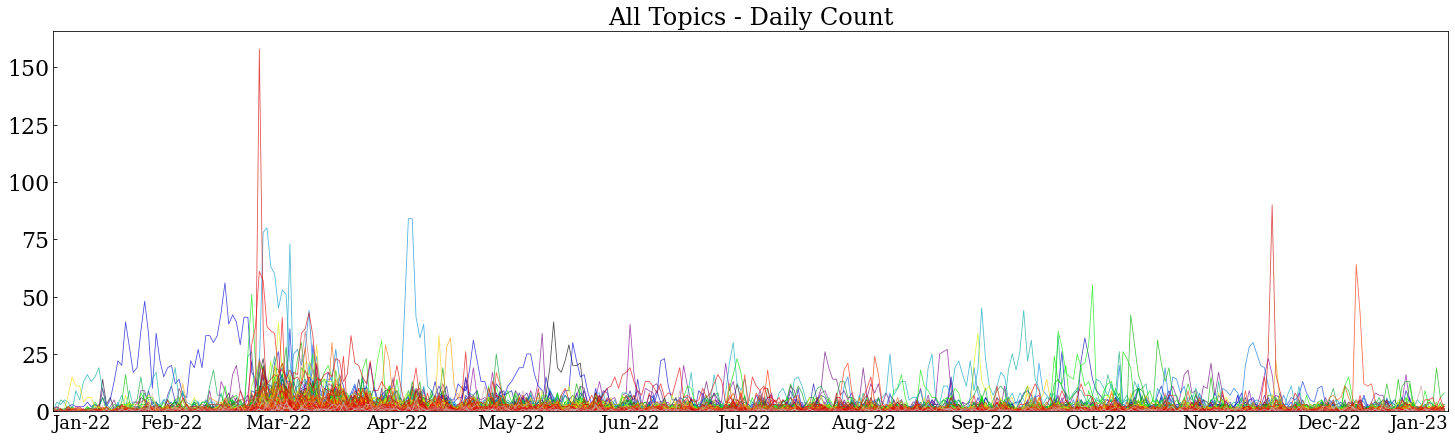

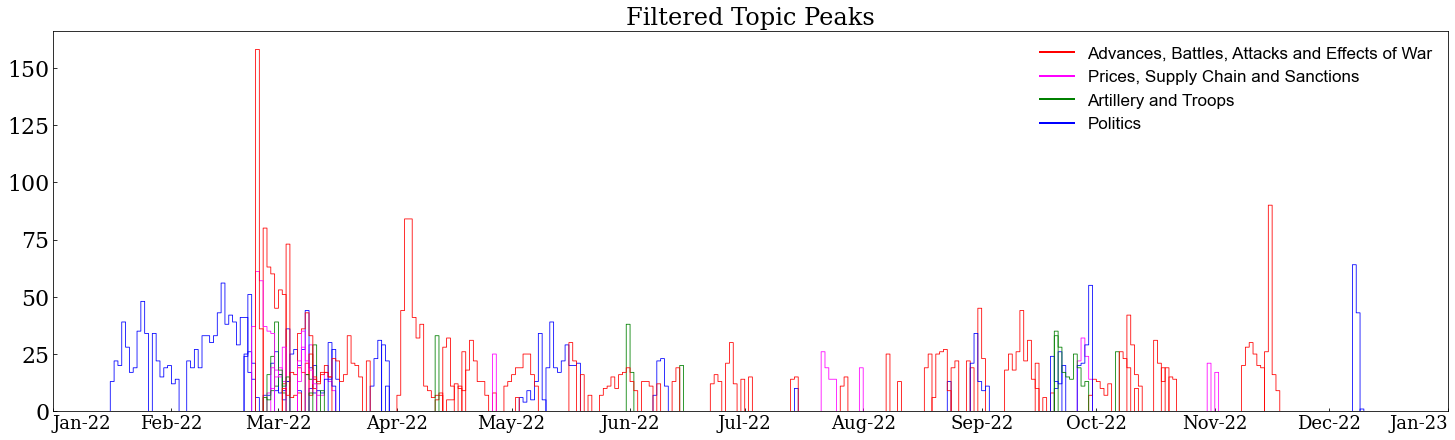

In [118]:
data_df = pd.read_csv(os.path.join(ROOT_DIR, "results_10", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
data_df = pd.get_dummies(data_df.filter(["Topic"]), columns=['Topic'])
data_df = data_df.resample("D").sum()

fig = multi_line_peaks_plot(data_df, f"All Topics - Daily Count", threshold=0)
fig.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Full_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")

fig2 = filtered_multi_lines_peaks_plot(data_df,kwargs,0)
fig2.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Filtered_topic_count.svg"), format="svg", dpi=1000, bbox_inches="tight")

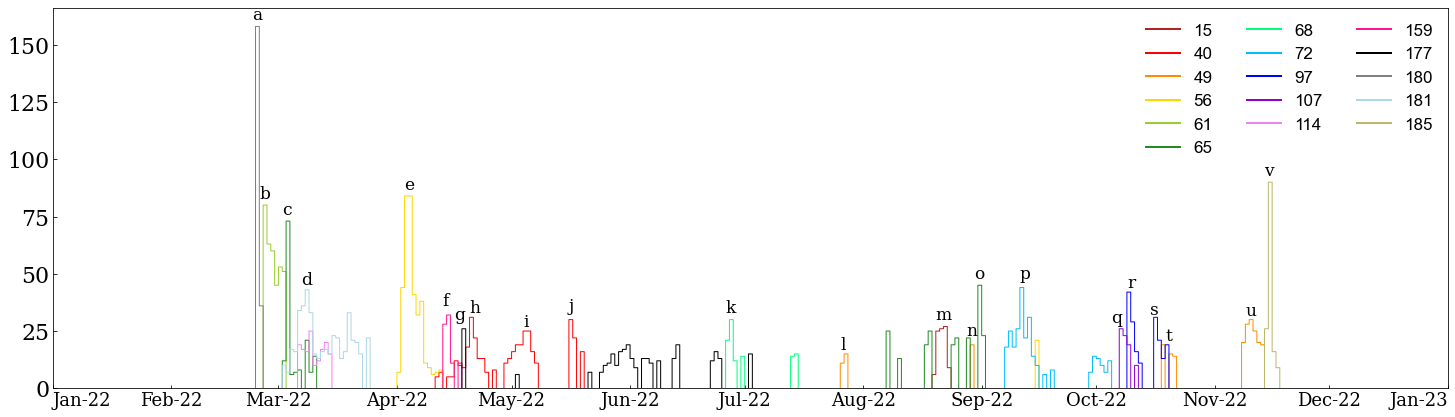

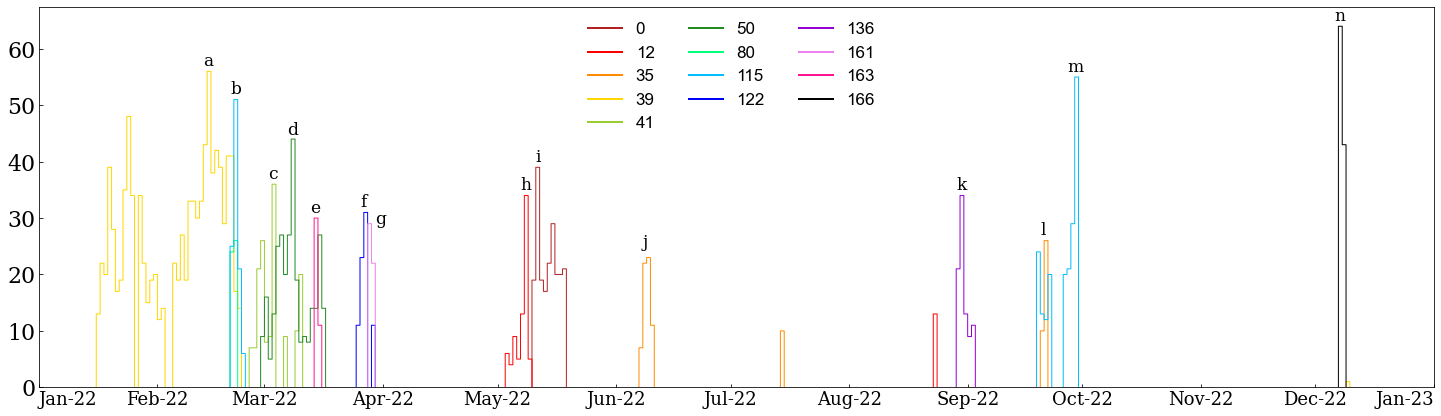

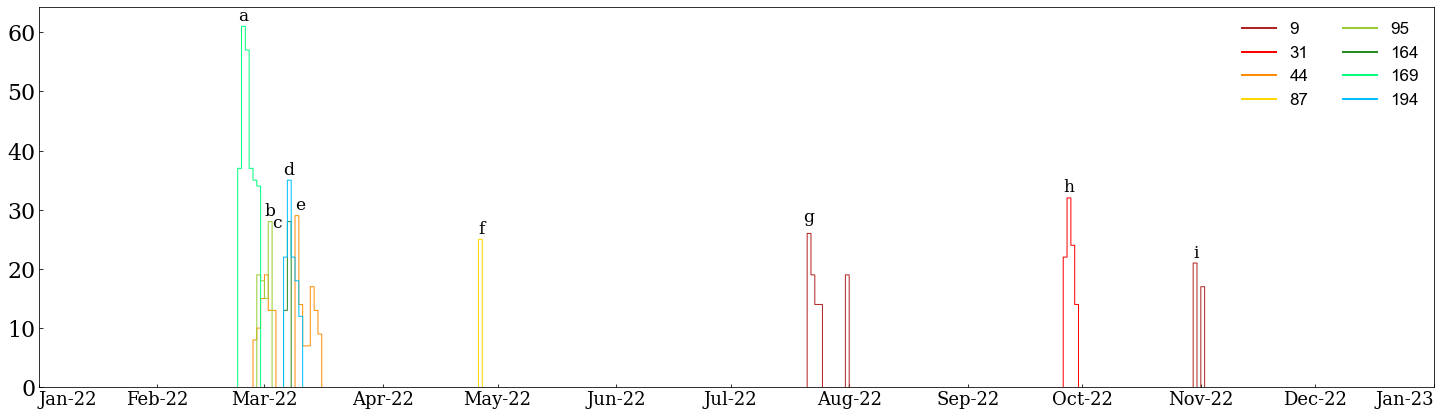

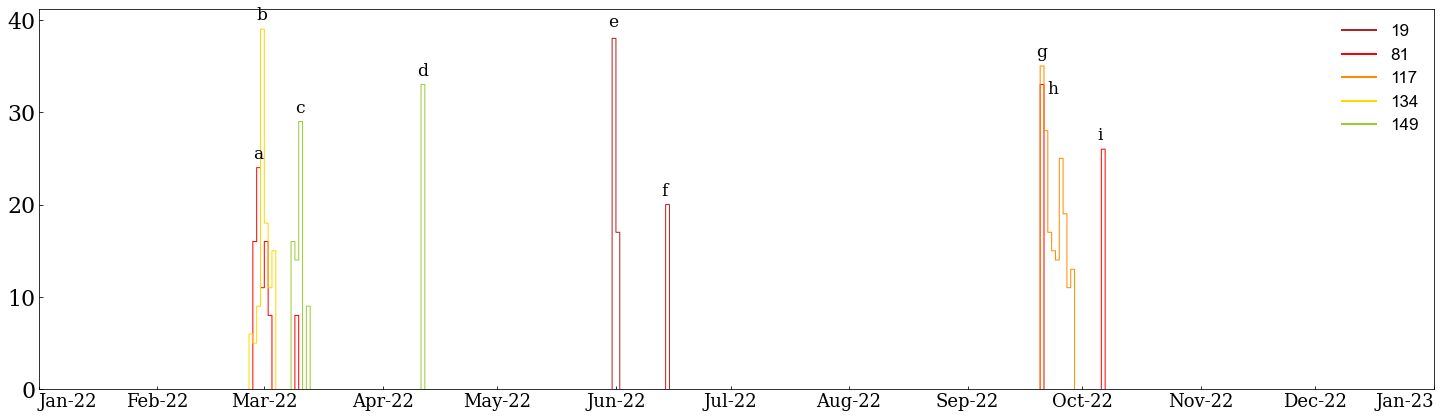

In [122]:
cats = [
    'bat',
    'pol',
    'pri',
    'art',
]

columns = [3,3,2,1]

positions = [
    [(dt.date(2022,2,22),161,'a','k'),
    (dt.date(2022,2,24),83,'b','k'),
    (dt.date(2022,3,2),76,'c','k'),
    (dt.date(2022,3,7),45.5,'d','k'),
    (dt.date(2022,4,3),87,'e','k'),
    (dt.date(2022,4,13),36,'f','k'),
    (dt.date(2022,4,16),30,'g','k'),
    (dt.date(2022,4,20),33,'h','k'),
    (dt.date(2022,5,4),27,'i','k'),
    (dt.date(2022,5,16),34,'j','k'),
    (dt.date(2022,6,26),33,'k','k'),
    (dt.date(2022,7,26),17,'l','k'),
    (dt.date(2022,8,20),30,'m','k'),
    (dt.date(2022,8,28),23,'n','k'),
    (dt.date(2022,8,30),48,'o','k'),
    (dt.date(2022,9,11),48,'p','k'),
    (dt.date(2022,10,5),29,'q','k'),
    (dt.date(2022,10,9),44,'r','k'),
    (dt.date(2022,10,15),32.4,'s','k'),
    (dt.date(2022,10,19),21,'t','k'),
    (dt.date(2022,11,9),32,'u','k'),
    (dt.date(2022,11,14),93,'v','k'),],
    [(dt.date(2022,2,13),57,'a','k'),
    (dt.date(2022,2,20),52,'b','k'),
    (dt.date(2022,3,2),37,'c','k'),
    (dt.date(2022,3,7),44.8,'d','k'),
    (dt.date(2022,3,13),31,'e','k'),
    (dt.date(2022,3,26),32,'f','k'),
    (dt.date(2022,3,30),29,'g','k'),
    (dt.date(2022,5,7),35,'h','k'),
    (dt.date(2022,5,11),40,'i','k'),
    (dt.date(2022,6,8),25,'j','k'),
    (dt.date(2022,8,29),35,'k','k'),
    (dt.date(2022,9,20),27,'l','k'),
    (dt.date(2022,9,27),56,'m','k'),
    (dt.date(2022,12,6),65,'n','k'),],
    [(dt.date(2022,2,22),62,'a','k'),
    (dt.date(2022,3,1),29,'b','k'),
    (dt.date(2022,3,3),27,'c','k'),
    (dt.date(2022,3,6),36,'d','k'),
    (dt.date(2022,3,9),30,'e','k'),
    (dt.date(2022,4,26),26,'f','k'),
    (dt.date(2022,7,20),28,'g','k'),
    (dt.date(2022,9,26),33,'h','k'),
    (dt.date(2022,10,30),22,'i','k')],
    [(dt.date(2022,2,26),25,'a','k'),
    (dt.date(2022,2,27),40,'b','k'),
    (dt.date(2022,3,9),30,'c','k'),
    (dt.date(2022,4,10),34,'d','k'),
    (dt.date(2022,5,30),39.3,'e','k'),
    (dt.date(2022,6,13),21,'f','k'),
    (dt.date(2022,9,19),36,'g','k'),
    (dt.date(2022,9,22),32,'h','k'),
    (dt.date(2022,10,5),27,'i','k'),]
]

for cat,pos,col in zip(cats,positions,columns):
    clist = [
        "firebrick",
        "red",
        "darkorange",
        "gold",
        "yellowgreen",
        "forestgreen",
        "springgreen",
        "deepskyblue",
        "blue",
        "darkviolet",
        "violet",
        "deeppink",
        "black",
        "grey",
        "lightblue",
        "darkkhaki"
    ]
    fig3 = category_plot(data_df,kwargs,0,chosen_cat=cat,lim=180,clist=clist,tuples=pos,columns=col)
    fig3.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Category_plot_{cat}.svg"), format="svg", dpi=1000, bbox_inches="tight")


In [120]:
# def category_plot_res_highlight(df, kwargs, limit, chosen_cat, lim, clist,tuples,columns):

#     def most_resonant_story_dates(cats,cat):
#         dates = {}
#         df = pd.read_csv(os.path.join(ROOT_DIR,"results_05","All_Results.csv"), parse_dates=["Date"], index_col="Date")
#         dq = df.filter(["Topic"])
#         dq = pd.get_dummies(dq, columns=['Topic'])
#         dq = dq.resample("D").sum()
#         for i in cats[cat]:
#             dfq = df.query(f"Topic == {i}")
#             dfq = dfq.sort_values(by="Resonance",ascending=False)
#             dates[i]=[datetime.strptime(str(i)[:10],"%Y-%m-%d") for i in dfq.index.tolist()[-5:]]
        
#         return dates

#     lizt = pd.read_csv(os.path.join(ROOT_DIR,"results_05","All_Results.csv"), parse_dates=["Date"], index_col="Date")
#     lizt = lizt.sort_values(by="Resonance",ascending=True)
#     lizt = lizt.filter(["Topic","Resonance"])
#     lizt = lizt.head(50)

#     cats = {
#         "bat":[15, 56, 61, 65, 68, 72, 107, 134, 159, 166, 177, 180, 181, 185, 114],
#         "pol":[0, 35, 39, 80, 115, 122, 161, 163],
#         "pri":[9, 31, 44, 87, 95, 164, 169, 194],
#         "art":[19, 40, 49, 72, 81, 97, 117, 149],
#         "oth":[12, 41, 50, 136, 153],
#     }
#     titles = {
#         "bat":"Advances, Battles, Attacks and Effects of War",
#         "pol":"Politics",
#         "pri":"Prices, Supply Chain and Sanctions",
#         "art":"Artillery and Troops",
#         "oth":"Other",
#     }
    
#     cat_topics = cats.get(chosen_cat)
#     if not cat_topics:
#         return None
#     resonant_dates = most_resonant_story_dates(cats,chosen_cat)

#     fig, ax = plt.subplots(figsize=(25, 7))
#     beginning = dt.date(2022, 1, 1)
#     end = dt.date(2023,1,1)
#     title = "Filtered Topic Peaks"
    
#     color_list = clist
#     c = -1

#     for i in kwargs["All"]:
#         topic = i["topic"]
#         if topic not in cat_topics:
#             continue
#         c+=1
#         lag = i["lag"]
#         threshold = i["threshold"]
#         topic_data = prepare_topics(df,lag,threshold)
#         signals = topic_data[f"signals_topic_{topic}"]
#         y = topic_data[f"y_{topic}"]

#         if max(signals) >= limit:
#             ax.step(topic_data.index.values, signals, lw=1, alpha=1,label=topic, c=color_list[c])
#             dates = lizt[lizt["Topic"]==topic].index.tolist()
#             for date in dates:
#                 plt.scatter(date,signals.loc[date],c=color_list[c])

#         for i in range(len(signals)):
#             if signals[i] >= lim:
#                 ax.text(topic_data.index.values[i], signals[i], str(int(signals[i])), ha='center', va='bottom', fontsize=9)

#     # for tuple in tuples:
#     #     ax.annotate(tuple[2], xy=(tuple[0], tuple[1]), xycoords='data', fontsize=17, color=tuple[3])

#     ax.set(title=f"{titles.get(chosen_cat)} - Peaks", xbound=(beginning, end), ylim=(0))

#     date_form = DateFormatter("%b-%y")
#     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#     ax.xaxis.set_major_formatter(date_form)
    
#     start, end = ax.get_ylim()
#     L = ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=columns)
#     plt.setp(L.texts, family='Arial') 
#     L.get_frame().set_linewidth(0.0)
#     for legobj in L.legendHandles:
#         legobj.set_linewidth(2)
#     ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
#     ticks[0].set_horizontalalignment("left")
#     ticks[-1].set_horizontalalignment("right")
    
#     plt.show()
    
#     return fig

# for cat,pos,col in zip(cats,positions,columns):
#     clist = [
#         "firebrick",
#         "red",
#         "darkorange",
#         "gold",
#         "yellowgreen",
#         "forestgreen",
#         "springgreen",
#         "deepskyblue",
#         "blue",
#         "darkviolet",
#         "violet",
#         "deeppink",
#         "black",
#         "grey",
#         "lightblue",
#     ]
#     fig3 = category_plot_res_highlight(data_df,kwargs,0,chosen_cat=cat,lim=180,clist=clist,tuples=pos,columns=col)
#     fig3.savefig(os.path.join(ROOT_DIR, "figures","topic_counts", f"Category_plot_{cat}.svg"), format="svg", dpi=1000, bbox_inches="tight")

In [121]:

# events = pd.read_csv(os.path.join(ROOT_DIR,"data","Ukraine_Black_Sea_2020_2023_Jan20.csv"), parse_dates=["EVENT_DATE"], index_col="EVENT_DATE")
# events = events[["FATALITIES","EVENT_TYPE","LOCATION","NOTES"]].loc["2021-07-01":"2022-12-31"].sort_index()
# # events = events.query("FATALITIES > 50")
# # events.iloc[50:100,:]
# events = events[["EVENT_TYPE","FATALITIES"]].rename(columns={"EVENT_DATE":"Date","EVENT_TYPE":"Count","FATALITIES":"Fatalities"})  # pegando somente colunas relevantes
# events = pd.get_dummies(events, columns=["Count"], prefix="", prefix_sep="")  # transformando em dummies
# events = events.resample("D").sum()


# def events_vs_topics(df, kwargs, limit, chosen_cat, lim, clist):

#     cats = {
#         "bat":[15, 56, 61, 65, 68, 72, 107, 134, 159, 166, 177, 180, 181, 185, 114],
#         "pol":[0, 35, 39, 80, 115, 122, 161, 163],
#         "pri":[9, 31, 44, 87, 95, 164, 169, 194],
#         "art":[19, 40, 49, 72, 81, 97, 117, 149],
#         "oth":[12, 41, 50, 136, 153],
#     }
#     titles = {
#         "bat":"Advances, Battles, Attacks and Effects of War",
#         "pol":"Politics",
#         "pri":"Prices, Supply Chain and Sanctions",
#         "art":"Artillery and Troops",
#         "oth":"Other",
#     }
    
#     cat_topics = cats.get(chosen_cat)
#     if not cat_topics:
#         return None

#     fig, ax = plt.subplots(figsize=(25, 7))
#     beginning = dt.date(2022, 1, 1)
#     end = dt.date(2023,1,1)
#     title = "Filtered Topic Peaks"
    
#     color_list = clist
#     c = -1

#     df2 = pd.DataFrame(0, index=df.index, columns=["y"])
#     for i in cat_topics:
#         df2[f"Topic_{i}"] = df[f"Topic_{i}"]
#     df2["y"] = df2.sum(axis=1)
#     ax.plot(df.index.values, df2["y"], lw=1, alpha=1,label="Filtered Topics", c="k")

#     ax.set(title=f"{titles.get(chosen_cat)} - Peaks", xbound=(beginning, end), ylim=(0))
#     date_form = DateFormatter("%b-%y")
#     ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#     ax.xaxis.set_major_formatter(date_form)
#     start, end = ax.get_ylim()

#     ax2 = ax.twinx()
#     ax2.plot(df.index.values, events["Strategic developments"], c="m",lw=0.8)
#     # ax2.plot(df.index.values, events["Fatalities"], c="m",lw=0.8)
#     # ax2.plot(df.index.values, events["Battles"], c="m",lw=0.8)
#     # ax2.plot(df.index.values, events["Explosions/Remote violence"], c="g",lw=0.3)
#     # ax2.plot(df.index.values, events["Violence against civilians"], c="m",lw=0.8)

#     L = ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=columns)
#     plt.setp(L.texts, family='Arial') 
#     L.get_frame().set_linewidth(0.0)
#     for legobj in L.legendHandles:
#         legobj.set_linewidth(2)
#     ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
#     ticks[0].set_horizontalalignment("left")
#     ticks[-1].set_horizontalalignment("right")
    
#     plt.show()
    
#     return fig

# for cat in cats:
#     clist = [
#         "firebrick",
#         "red",
#         "darkorange",
#         "gold",
#         "yellowgreen",
#         "forestgreen",
#         "springgreen",
#         "deepskyblue",
#         "blue",
#         "darkviolet",
#         "violet",
#         "deeppink",
#         "black",
#         "grey",
#         "lightblue",
#     ]
#     fig3 = events_vs_topics(data_df,kwargs,0,chosen_cat=cat,lim=180,clist=clist)

